In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import micasense.image as image
import micasense.capture as capture
import os, glob
from pathlib import Path

In [3]:
# Set the base path to your data
imagePath = Path("../data/tabakas_hand")

# Identify the survey (actual) images
# Replace 'IMG_0015_*' with the prefix for your specific survey capture
imageNames = list(imagePath.glob('IMG_0015_*.tif'))
imageNames = [x.as_posix() for x in imageNames]

# Identify the calibration panel images
# Replace 'IMG_0002_*' with the prefix for your panel capture
panelNames = list(imagePath.glob('IMG_0002_*.tif'))
panelNames = [x.as_posix() for x in panelNames]

print(f"Survey images found ({len(imageNames)}):")
for name in imageNames: print(f" - {os.path.basename(name)}")

print(f"\nPanel images found ({len(panelNames)}):")
for name in panelNames: print(f" - {os.path.basename(name)}")

Survey images found (6):
 - IMG_0015_1.tif
 - IMG_0015_2.tif
 - IMG_0015_3.tif
 - IMG_0015_4.tif
 - IMG_0015_5.tif
 - IMG_0015_6.tif

Panel images found (6):
 - IMG_0002_1.tif
 - IMG_0002_2.tif
 - IMG_0002_3.tif
 - IMG_0002_4.tif
 - IMG_0002_5.tif
 - IMG_0002_6.tif


In [4]:
# Load the survey images into a Capture object
survey_capture = capture.Capture.from_filelist(imageNames)

# Load the calibration panel images into a Capture object
panel_capture = capture.Capture.from_filelist(panelNames)

# Verification
print(f"Survey Capture ID: {survey_capture.uuid} ({survey_capture.camera_model})")
print(f"Panel Capture ID: {panel_capture.uuid} ({panel_capture.camera_model})")

Survey Capture ID: LX6b8pI0Jo63smUwSgOi (RedEdge-P)
Panel Capture ID: 726xKPzkyWOW0qbpHM2r (RedEdge-P)


##  <p style="color:blue; font-size:18px">Foto uŽkrautos, toliau skaičiuosim atspindžius</p>

In [6]:
# Use the panel_capture to calculate the irradiance (incoming light)
# This looks for the calibration panel in the images
irradiance_list = panel_capture.panel_irradiance() 

# Verify we got a value for each band (usually 5 or 6 values)
print(f"Irradiance values per band: {irradiance_list}")

Irradiance values per band: [18.704439654165455, 14.564029876505934, 3.3120798599854453, 1.1460122825460848, 2.023102850243376, 54.82495721127014]


Sunlight intensity (Irradiance) per band: [18.704439654165455, 14.564029876505934, 3.3120798599854453, 1.1460122825460848, 2.023102850243376, 54.82495721127014]
--- SURVEY DATA: RAW (BEFORE) ---


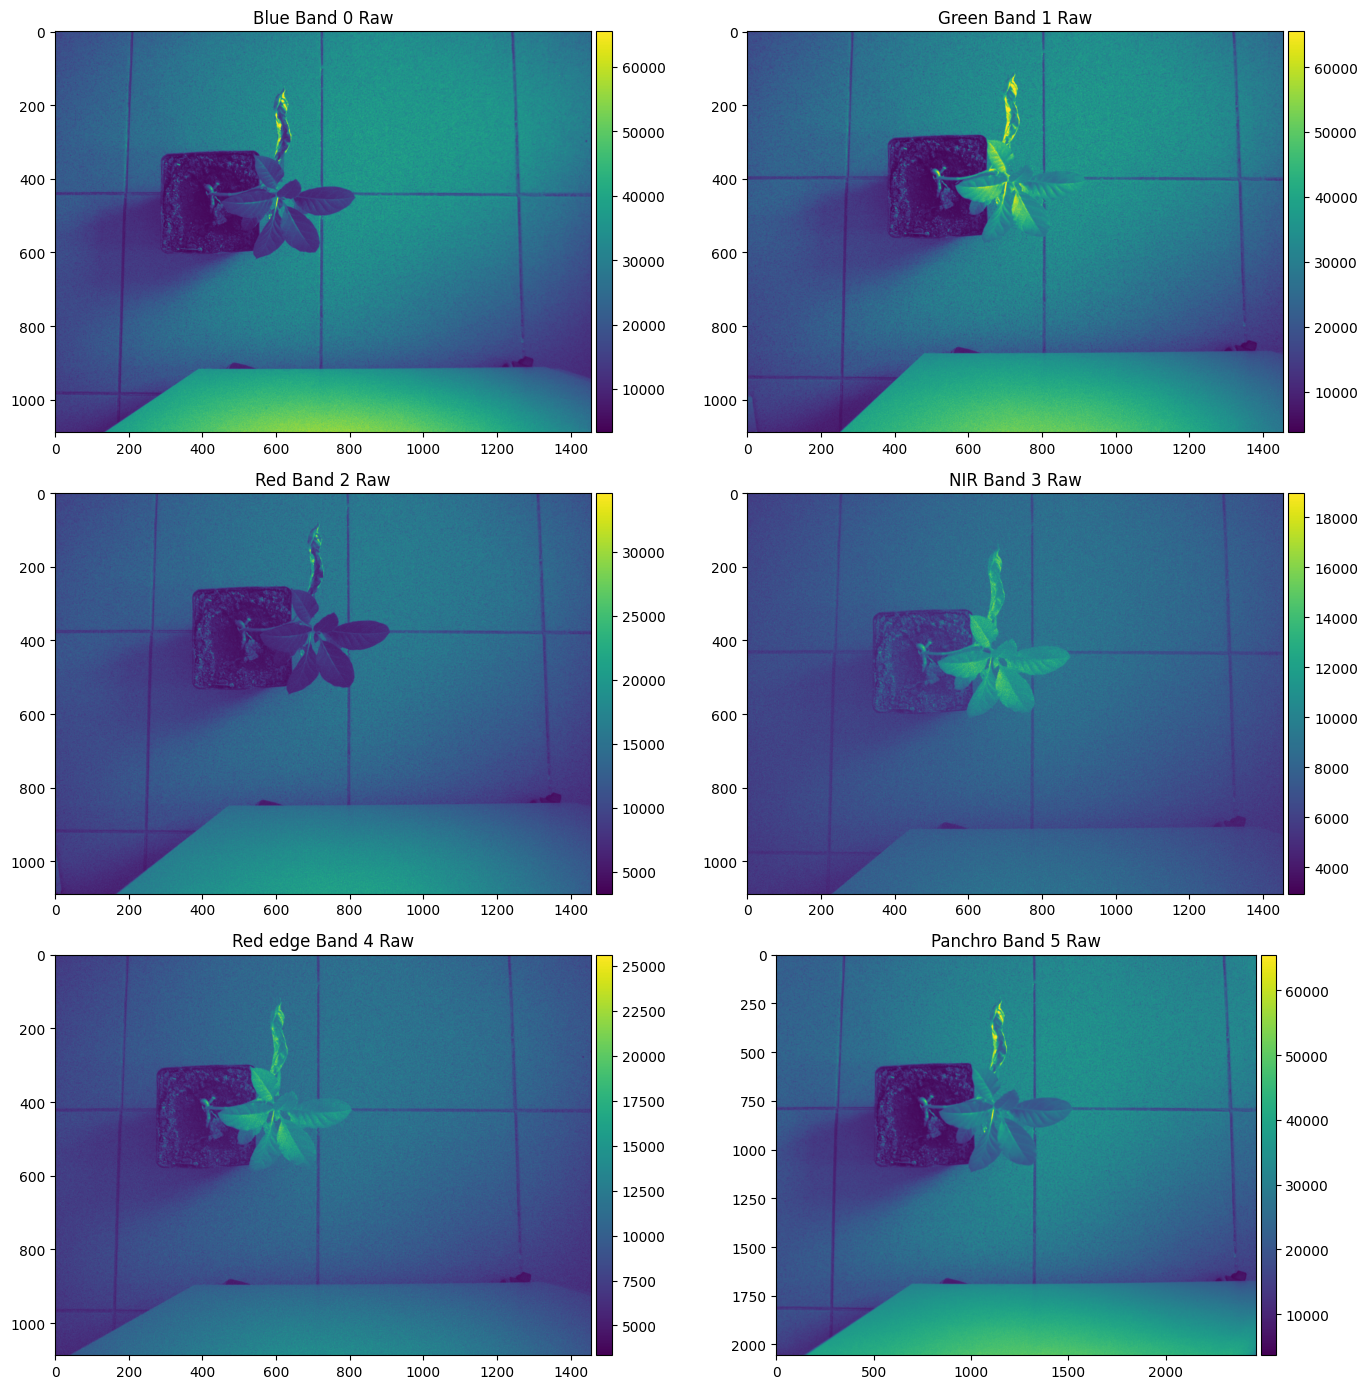

--- SURVEY DATA: REFLECTANCE (AFTER) ---


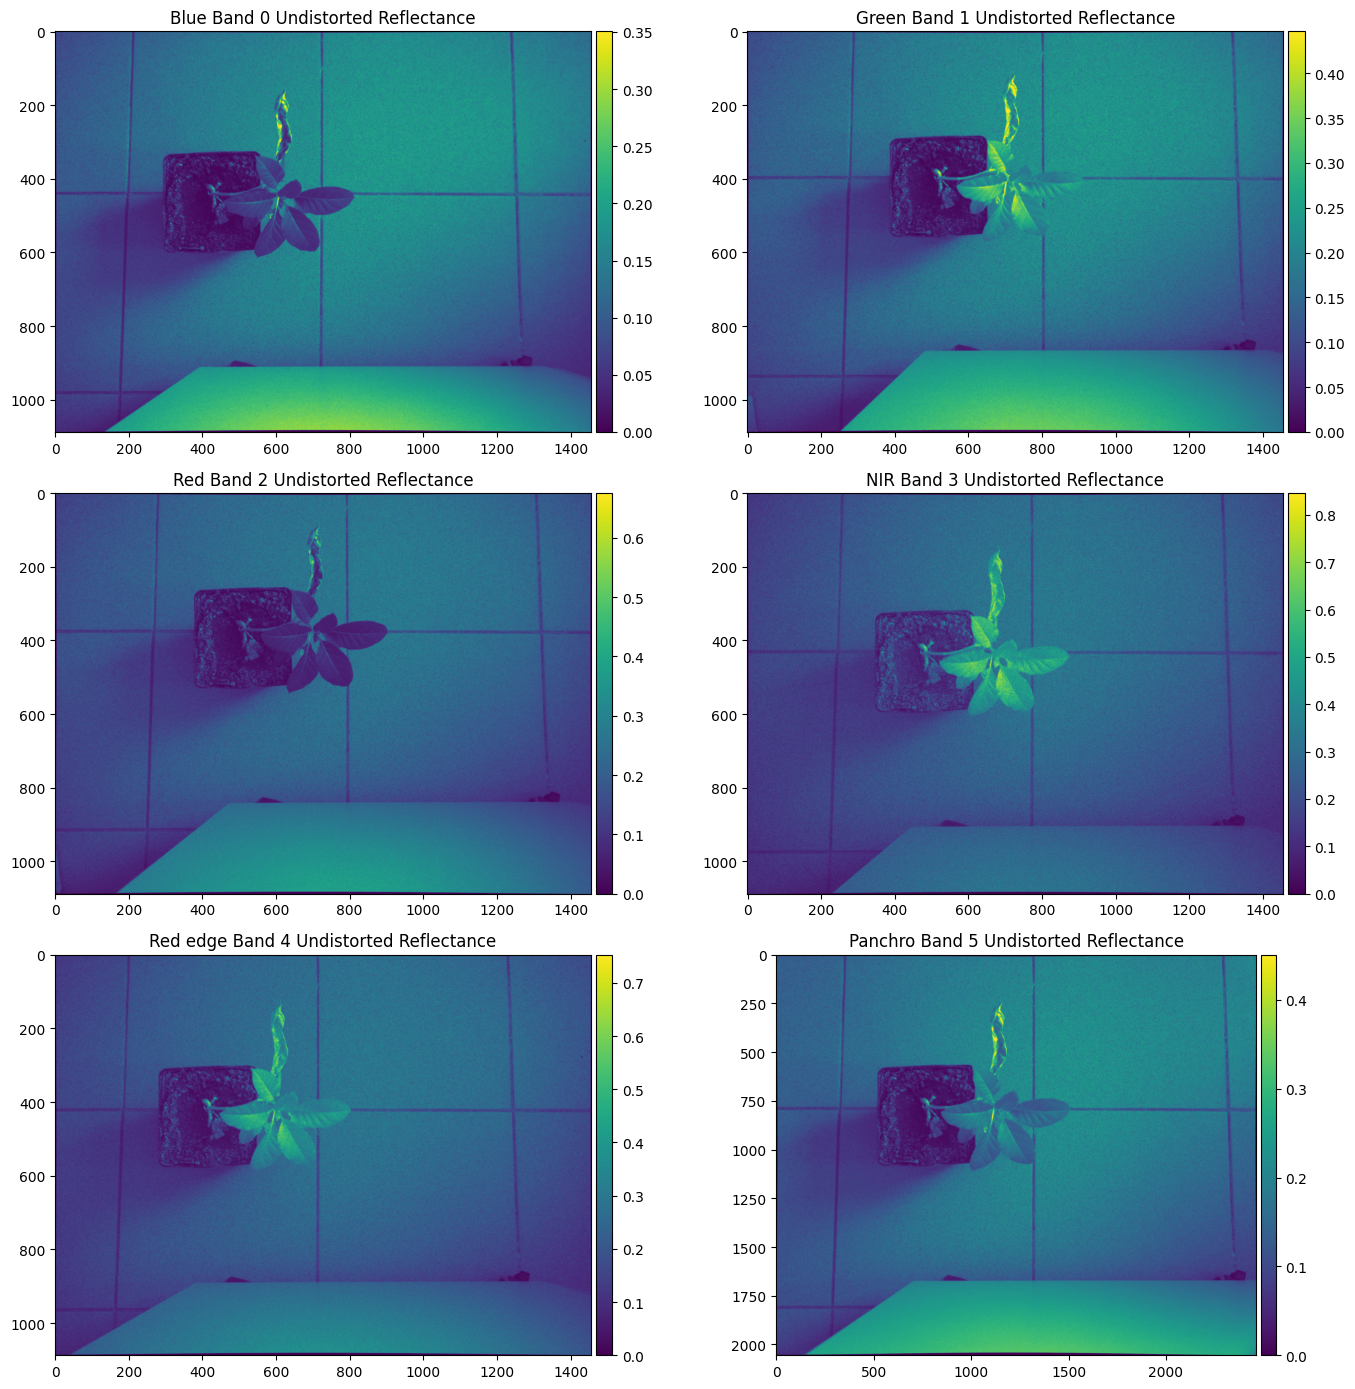

In [7]:
# 2. BEFORE: Show the raw, uncalibrated survey photos
# (Expect: Dark corners, "funny" colors, 0-65535 scale)
print("--- SURVEY DATA: RAW (BEFORE) ---")
survey_capture.plot_raw()

# 3. AFTER: Show the calibrated reflectance survey photos
# (Expect: Even brightness, scientific 0.0-1.0 scale)
# Note: We use 'plot_undistorted_reflectance' to see the corrected images
print("--- SURVEY DATA: REFLECTANCE (AFTER) ---")
survey_capture.plot_undistorted_reflectance(irradiance_list)

In [15]:
import numpy as np

# 1. Select the Red band (index 2)
img = survey_capture.images[2]

# 2. Access the data arrays directly
# We'll grab a 3x3 patch from the middle of the image
radiance_data = img.undistorted_radiance()
reflectance_data = img.reflectance()

height, width = radiance_data.shape
cy, cx = height // 2, width // 2
patch_size = 1

# --- BEFORE: Radiance (Raw Sensor Power) ---
radiance_patch = radiance_data[cy-patch_size:cy+patch_size+1, cx-patch_size:cx+patch_size+1]
print(f"--- Radiance (Raw Power) ---")
print(radiance_patch)

# --- AFTER: Reflectance (0.0 - 1.0) ---
# Note: Ensure survey_capture.compute_reflectance(irradiance_list) was run
reflectance_patch = reflectance_data[cy-patch_size:cy+patch_size+1, cx-patch_size:cx+patch_size+1]
print(f"\n--- Calibrated Reflectance (Scientific 0-1) ---")
print(np.round(reflectance_patch, 4))

--- Radiance (Raw Power) ---
[[0.29598437 0.23901367 0.23943288]
 [0.26021499 0.21713445 0.2112011 ]
 [0.25260116 0.23012831 0.20555944]]

--- Calibrated Reflectance (Scientific 0-1) ---
[[0.2262 0.2582 0.2457]
 [0.2329 0.2418 0.2489]
 [0.2578 0.2973 0.2461]]


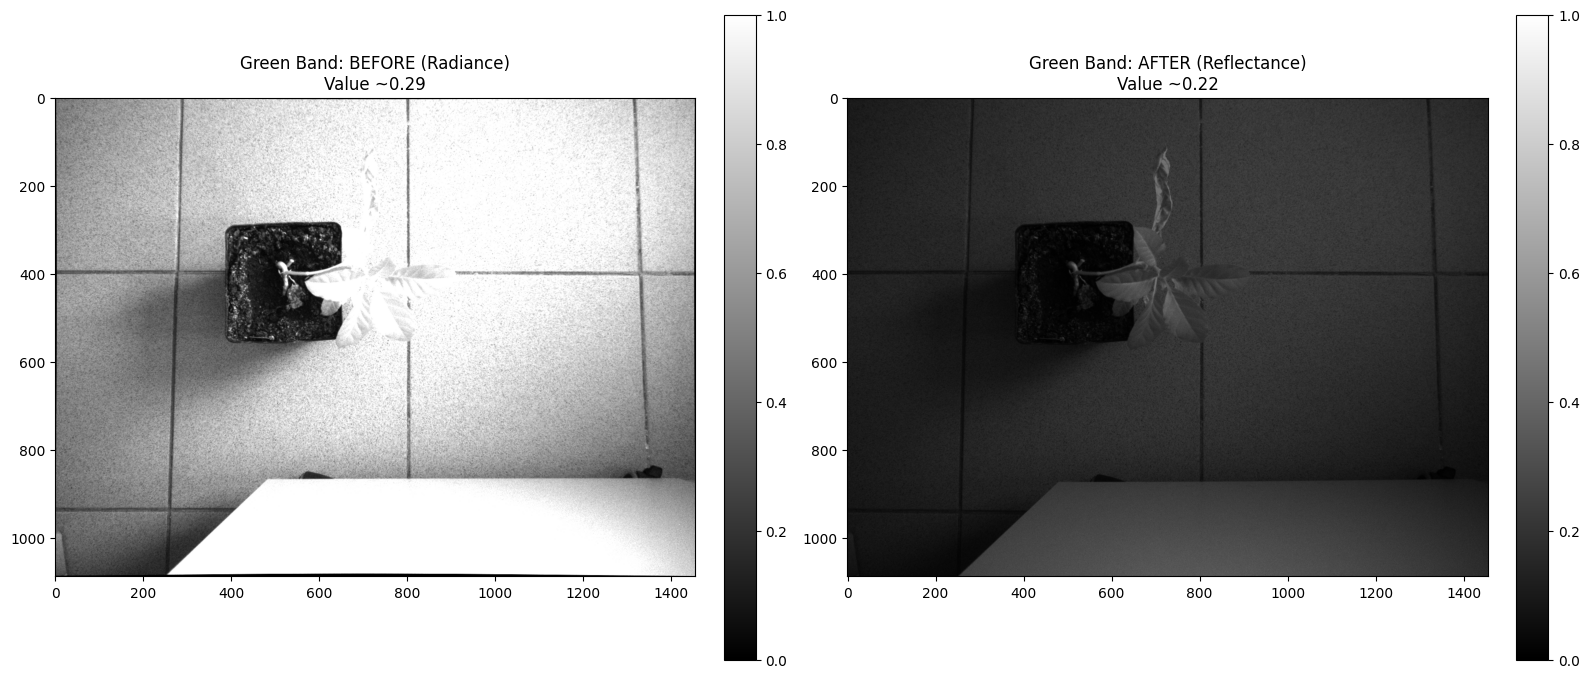

In [16]:
import matplotlib.pyplot as plt

# 1. Get the Green band
green_band_idx = 1
img = survey_capture.images[green_band_idx]

# 2. Get the two data versions
# 'undistorted_radiance' is the raw power (the 0.29... values)
# 'reflectance' is the calibrated value (the 0.22... values)
before_data = img.undistorted_radiance()
after_data = img.reflectance()

# 3. Plot side-by-side with a FIXED scale (0.0 to 1.0)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Before Calibration
im0 = axes[0].imshow(before_data, vmin=0, vmax=1, cmap='gray')
axes[0].set_title(f"Green Band: BEFORE (Radiance)\nValue ~0.29")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# After Calibration
im1 = axes[1].imshow(after_data, vmin=0, vmax=1, cmap='gray')
axes[1].set_title(f"Green Band: AFTER (Reflectance)\nValue ~0.22")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()